In [4]:
import ete3
import os
import pandas as pd
from Bio import Phylo as phy
from Bio import SeqIO, SearchIO, AlignIO, Align, Alphabet
import subprocess
import numpy as np
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import seaborn as sns
import multiprocessing

os.chdir('/work/site_rate/hug_et_al')
ncbi = ete3.NCBITaxa()
%matplotlib inline

In [5]:
class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

In [6]:
tree = ete3.Tree('ribosomal_concat.fasta.treefile', format=1)
bacteria     = []
archaea      = []
eukarya      = []
for leaf in tree.get_leaf_names():
    if leaf.startswith('Bacteria'):
        bacteria.append(leaf)
    elif leaf.startswith('Archaea'):
        archaea.append(leaf)
    elif leaf.startswith('Eukaryota'):
        eukarya.append(leaf)

tree.set_outgroup(eukarya[0])
bacteria_ancestor = tree.get_common_ancestor(bacteria)
tree.set_outgroup(bacteria_ancestor)

In [13]:
branch_length = np.asarray([node.dist for node in tree.traverse() if not node.is_leaf() and not node.is_root()])

In [14]:
np.median(branch_length)

0.0495251131

In [27]:
a = ete3.Tree('(((a,b),c),d);')
b = ete3.Tree('(((c,b),a),d);')
print a
print b
for n in a.robinson_foulds(b):
    print n


         /-a
      /-|
   /-|   \-b
  |  |
--|   \-c
  |
   \-d

         /-c
      /-|
   /-|   \-b
  |  |
--|   \-a
  |
   \-d
2
4
set(['a', 'c', 'b', 'd'])
set([('a',), ('c',), ('b',), ('d',), ('a', 'b'), ('a', 'b', 'c', 'd'), ('a', 'b', 'c')])
set([('b', 'c'), ('a',), ('c',), ('b',), ('d',), ('a', 'b', 'c'), ('a', 'b', 'c', 'd')])
set([])
set([])


In [ ]:
tree.write(outfile='species.tre', dist_formatter='%.20f', format=5)

In [ ]:
num_categories = 12
alignment      = AlignIO.read('ribosomal_concat.fasta', 'fasta')
subprocess.call(['iqtree', '-s', 'ribosomal_concat.fasta', '-keep-ident',
                 '-nt', '15', '-redo', '-m', 'LG+F+G%i' %num_categories,
                 '-safe', '-wsr', '-te', 'species.tre', '-pre', 'rate_binning'])

In [16]:
rates = pd.read_table('rate_binning.rate', comment='#')
rates.drop_duplicates('Cat')

,Site,Rate,Cat,C_Rate
0,1,0.08971,2,0.08971
1,2,1.19779,9,1.21474
2,3,0.54594,6,0.54580
7,8,0.40146,5,0.40042
10,11,0.93815,8,0.93721
11,12,0.72080,7,0.72100
28,29,1.54310,10,1.59572
29,30,2.19435,11,2.19435
34,35,0.27794,4,0.27821
47,48,0.17520,3,0.17524


In [34]:
1.59572*215

343.0798

1 93
2 183
3 188
4 246
5 285
6 281
7 294
8 274
9 286
10 215
11 194
12 57


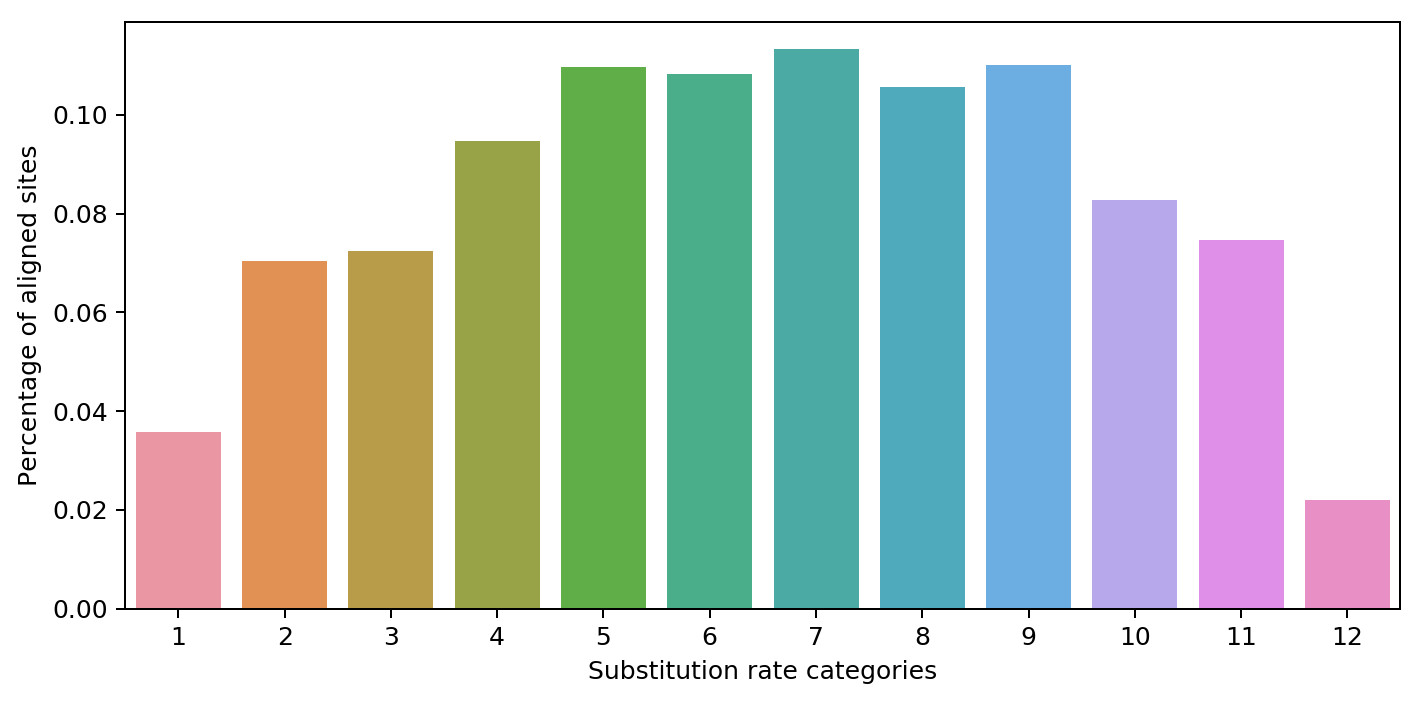

In [30]:
rates     = pd.read_table('rate_binning.rate', comment='#')
category_frequencies = []
for category in range(1,13):
    category_length = sum(rates.Cat==category)
    category_frequencies.append(category_length/2596.)
    print category, category_length

fig, ax = plt.subplots(dpi=180, figsize=(8,4))
sns.barplot(x=range(1,13), y=category_frequencies)
ax.set_xlabel('Substitution rate categories')
ax.set_ylabel('Percentage of aligned sites')
fig.tight_layout()

In [5]:
alignment      = AlignIO.read('ribosomal_concat.fasta', 'fasta')
alignment.get_alignment_length()

2596

In [ ]:
for category in rates.Cat.unique():
    site_df        = rates[rates.Cat == category]
    category_aln   = {sequence.name:'' for sequence in alignment}
    for sequence in alignment:
        category_aln[sequence.name] = ''.join([sequence[position] for position in site_df.index])

    out = open('categories/%i.aln' % category, 'w')
    for header, sequence in category_aln.items():
        full_sequence = ''
        while len(full_sequence) <= 2596:
            full_sequence += sequence
        out.write('>%s\n%s\n' % (header, full_sequence[:2596]))
    out.close()

In [ ]:
def run_bootstrap(category):
    subprocess.call(['iqtree', '-s', '%i.aln' % category, '-m', 'LG+G1', '-redo',
                     '-safe', '-nt', '1', '-pre', '%i' % category,
                     '-alrt', '1000', '-keep-ident', '-quiet', '-te', '../species.tre'])


with cd('categories'):
    pool = multiprocessing.Pool(processes=12)
    pool.map(run_bootstrap, range(1, 13))

In [6]:
sorted_taxa = []
for sequence in alignment:
    sorted_taxa.append(sequence.name)

In [ ]:
subprocess.call(['iqtree', '-s', 'ribosomal_concat.fasta', '-keep-ident',
                  '-nt', '15', '-redo', '-m', 'LG+F+G12',
                 '-safe', '-te', 'BIONJ', '-pre', 'mldistances'])

In [7]:
ml_distances = pd.read_table('mldistances.mldist', index_col=0, header=None, skiprows=1, sep=r'\s*')
ml_distances.columns = ml_distances.index

fig, ax = plt.subplots()
with cd('categories'):
    for category in range(1, 13):
#        subprocess.call(['distmat', '-sequence', '%i.aln' % category,
#                         '-protmethod', '0', '-outfile', '%i.distmat' % category])
        uncorrected_distances = pd.read_table('%i.distmat' % category, skiprows=7, header=None, index_col=-1)
        uncorrected_distances.drop([0, 3084], axis='columns', inplace=True)
        uncorrected_distances.columns = uncorrected_distances.index = sorted_taxa

        lower_triangle_indexes = np.tril_indices(uncorrected_distances.shape[0], -1)
        uncorrected_distances.values[lower_triangle_indexes] = uncorrected_distances.T.values[lower_triangle_indexes]

        uncorrected_distances = uncorrected_distances.reindex(index=ml_distances.index,
                                                              columns=ml_distances.columns,
                                                              tolerance=0)

        plot = sns.scatterplot(squareform(ml_distances.values),
                        squareform(uncorrected_distances.values, checks=False),
                        ax=ax, label='category %i' % category, alpha=0.7, s=5
                        )

ax.set_xlabel('ML pairwise distances from original alignment')
ax.set_ylabel('Uncorrected distances from rate-category sites')

fig.set_size_inches(15,15)
fig.tight_layout()
fig.savefig('saturation_test-combined.png', dpi=300)
plt.close()

/Users/thiberio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [ ]:
colors = '#29bece #bcbc35 #7f7f7f #e17ac1 #8b564c #936abb #d42a2f #339f34 #fd7f28 #2678b2 #29bece #bcbc35 '.split()
colors.reverse()
fig, axs = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True)
with cd('categories'):
    row = col = 0
    for category in range(1, 13):
        if category  in [1,2,3,4]:
            row = 0
        elif category in [5,6,7,8]:
            row = 1
        else:
            row = 2

        if category in [1,5,9]:
            col = 0
        elif category in [2,6,10]:
            col = 1
        elif category in [3,7,11]:
            col = 2
        else:
            col = 3

        #subprocess.call(['distmat', '-sequence', '%i.aln' % category, '-protmethod', '0', '-outfile', '%i.distmat' % category])
        uncorrected_distances = pd.read_table('%i.distmat' % category, skiprows=7, header=None, index_col=-1)
        uncorrected_distances.drop([0, 132], axis='columns', inplace=True)
        uncorrected_distances.columns = uncorrected_distances.index = sorted_taxa

        lower_triangle_indexes = np.tril_indices(uncorrected_distances.shape[0], -1)
        uncorrected_distances.values[lower_triangle_indexes] = uncorrected_distances.T.values[lower_triangle_indexes]

        uncorrected_distances = uncorrected_distances.reindex(index=ml_distances.index,
                                                              columns=ml_distances.columns,
                                                              tolerance=0)

        plot = sns.scatterplot(squareform(ml_distances.values),
                               squareform(uncorrected_distances.values, checks=False),
                               ax=axs[row, col], label='category %i' % category, alpha=0.5,
                               color=colors[category-1]
                               )

commom_area = fig.add_subplot(111, frameon=False)
commom_area.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
commom_area.set_xlabel('ML pairwise distances from original alignment')
commom_area.set_ylabel('Uncorrected distances from rate-category sites')

fig.set_size_inches(18,14)
fig.tight_layout()
fig.savefig('saturation_test.png', dpi=300)
plt.close()